In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from get_data import *

### Data load

In [2]:
ds = get_data_model_v1()
ds.info()

Database object created
<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 723
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        724 non-null    int64  
 1   titulo                    724 non-null    object 
 2   descripcion               711 non-null    object 
 3   extra_info                720 non-null    object 
 4   n_habitaciones            724 non-null    int64  
 5   tamano                    724 non-null    int64  
 6   precio                    724 non-null    float64
 7   municipio                 724 non-null    object 
 8   n_banos                   713 non-null    float64
 9   n_plazas_garaje           713 non-null    float64
 10  direccion                 713 non-null    object 
 11  landmarks_cercanos        713 non-null    object 
 12  piscina                   724 non-null    bool   
 13  valoracion                713 non-null   

c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


In [3]:
object_columns = ds.select_dtypes(include=['object']).columns.tolist()
ds_object = ds[object_columns]
ds_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 723
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   titulo              724 non-null    object
 1   descripcion         711 non-null    object
 2   extra_info          720 non-null    object
 3   municipio           724 non-null    object
 4   direccion           713 non-null    object
 5   landmarks_cercanos  713 non-null    object
 6   zona                724 non-null    object
 7   zona_v2             704 non-null    object
dtypes: object(8)
memory usage: 50.9+ KB


In [4]:
cols = ds.columns
cols_exclude = ['id', 'titulo', 'descripcion', 'extra_info', 'direccion', 'landmarks_cercanos', 'municipio', 'zona', 'direccion_x', 'direccion_y']
cols_check_nas = ['n_banos', 'n_plazas_garaje', 'valoracion']
for col in cols_check_nas:
    if sum(ds[col]==-1)/len(ds) > 0.25:
        print(f'Column {col} has more than 20% of missing values.')
        cols_exclude.append(col)

cols_model = [col for col in cols if col not in cols_exclude]

#convert int and bool columns to float
for col in cols:
    if ds[col].dtype == 'int64':
        ds[col] = ds[col].astype('float64')
    elif ds[col].dtype == 'object':
        cols_exclude.append(col)
    elif ds[col].dtype == 'bool':
        ds[col] = ds[col].astype('float64')

Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


### Data exploration

Correlaciones

In [5]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']
abs(x.corrwith(y)).sort_values(ascending=False)

C:\Users\ivan\AppData\Local\Temp\ipykernel_13636\427371742.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(x.corrwith(y)).sort_values(ascending=False)


tamano                      0.660742
es_chalet                   0.496969
es_casa                     0.492154
n_habitaciones              0.436049
puntuacion                  0.426205
exclusivo                   0.277338
jardin                      0.275379
urbanizacion                0.264118
oleiros                     0.252610
amueblado                   0.247750
sin_ascensor                0.227913
padel                       0.205054
vistas                      0.182481
vacacional                  0.167707
ubicacion_excepcional       0.167328
piscina                     0.158946
estudiantes                 0.155953
maianca                     0.154163
reformado                   0.151655
soleado                     0.139347
pib_capita                  0.130230
playa                       0.113705
transporte                  0.101404
coruna                      0.101112
spa                         0.096378
equipado                    0.094354
densidad                    0.088680
d

### Data visualization

### Deal with NAs

In [7]:
for col in cols_check_nas:
    ds[col] = ds[col].fillna(np.mean(ds[col]))

### Data split

In [37]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']

# slit data into train and val
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Model: Linear reg

In [40]:
def train_model(x,y, model, n_splits=5, n_repeats=5, print_results=False):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    if print_results:
        rmse_train = [x['rmse_train'] for x in trainings]
        rmse_val = [x['rmse_val'] for x in trainings]
        mae_train = [x['mae_train'] for x in trainings]
        mae_val = [x['mae_val'] for x in trainings]

        print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
        print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
        print("")
        print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
        print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')
    return return_val

#### Linear reg

Repeated CV

In [41]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5, print_results=True)

RMSE train:	 mean 250.34	 std 14.86
RMSE val:	 mean 280.20	 std 52.67

MAE train:	 mean 162.62	 std 5.44
MAE val:	 mean 182.59	 std 17.40


LeaveOneOut

In [42]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1, print_results=True)

RMSE train:	 mean 321.44	 std 13.87
RMSE val:	 mean 370.65	 std 51.91

MAE train:	 mean 203.22	 std 6.06
MAE val:	 mean 230.38	 std 21.12


#### Variable selection

In [95]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

def perform_forward(x,y, model, cols_model):
    current_cols = []
    scores_train = []
    scores_val = []
    cols = []
    all_columns = cols_model[:]
    all_columns.remove('precio')

    for k in range(len(all_columns)-1):
        best_col = None
        best_score_training = 1e20
        best_score_val = 1e20
        best_model = None
        for col in set(all_columns)-set(current_cols):
            score_training, score_val = get_step_score(current_cols, col, x, y, model)
            if score_training < best_score_training:
                best_score_training = score_training
                best_score_val = score_val
                best_col = col
        current_cols.append(best_col)
        scores_train.append(best_score_training)
        scores_val.append(best_score_val)
        cols.append(current_cols[:])
        print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')
    return cols, scores_train, scores_val

In [96]:
cols, scores_train, scores_val = perform_forward(x,y, LinearRegression(), cols_model)

Best column: tamano	 score training:399.26	 score_val:527.13
Best column: puntuacion	 score training:383.78	 score_val:396.75
Best column: vacacional	 score training:372.58	 score_val:384.61
Best column: amueblado	 score training:363.48	 score_val:379.36
Best column: art_berg_camb	 score training:357.01	 score_val:364.74
Best column: estudiantes	 score training:353.25	 score_val:361.20
Best column: exclusivo	 score training:348.80	 score_val:361.86
Best column: distancia_centro_coruna	 score training:345.90	 score_val:354.11
Best column: padel	 score training:343.82	 score_val:355.86
Best column: transporte	 score training:341.70	 score_val:355.58
Best column: vistas	 score training:340.24	 score_val:360.22
Best column: ubicacion_excepcional	 score training:338.57	 score_val:358.01
Best column: reformado	 score training:336.33	 score_val:357.04
Best column: de_diseño	 score training:335.69	 score_val:359.23
Best column: es_casa	 score training:334.14	 score_val:353.78
Best column: dist

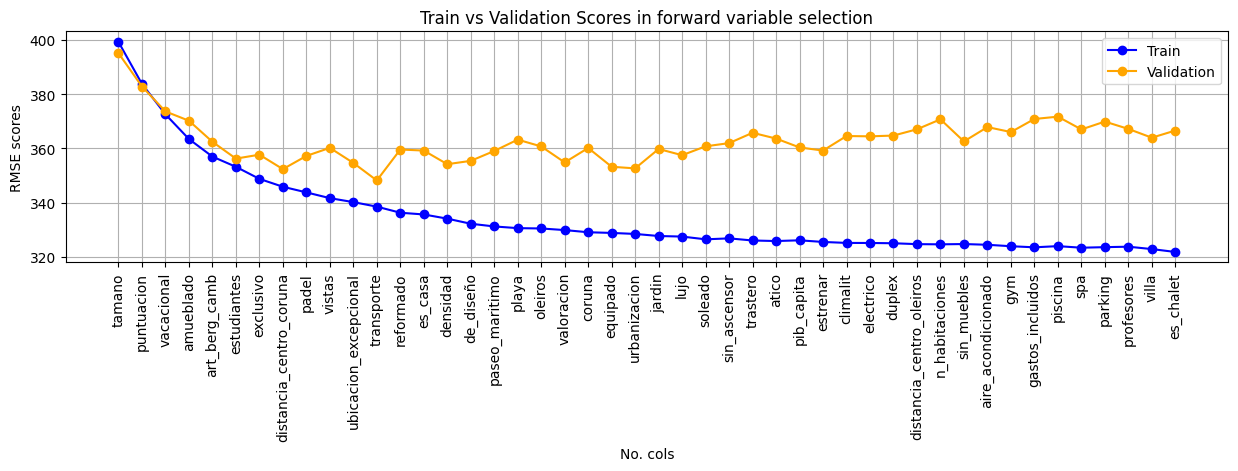

In [97]:
idx = list(range(len(current_cols)))
plt.figure(figsize=(15,3))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

#### Usando solo n_habitaciones y tamaño

In [34]:
ds_aux = ds[ds['municipio'].str.contains('oru')]
# ds_aux = ds
xx = ds_aux[cols_model]
xx = x.drop('precio', axis=1)
yy = ds_aux['precio']

trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=50, print_results=True)

RMSE train:	 mean 250.34	 std 14.86
RMSE val:	 mean 280.20	 std 52.67

MAE train:	 mean 162.62	 std 5.44
MAE val:	 mean 182.59	 std 17.40
